<a href="https://colab.research.google.com/github/JungWoo-Chae/GANs-in-action/blob/master/chapter-8/8_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 8: Conditional GAN**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

num_classes = 10

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        
        self.embed = torch.nn.Embedding(num_classes, z_dim)

        self.fc = nn.Linear(z_dim, 256*7*7)
        self.g_deconv_1 = nn.Sequential(
                          nn.ConvTranspose2d(256, 128, kernel_size=3,
                                    stride= 2, padding=(3-2+1)//2,
                                    output_padding = (3-2)%2), 
                          nn.BatchNorm2d(128),
                          nn.LeakyReLU()
                          )
        self.g_deconv_2 = nn.Sequential(
                          nn.ConvTranspose2d(128, 64, kernel_size=3,
                                    stride= 1, padding=(3-1+1)//2,
                                    output_padding = (3-1)%2), 
                          nn.BatchNorm2d(64),
                          nn.LeakyReLU()
                          )
        self.g_deconv_3 = nn.Sequential(
                          nn.ConvTranspose2d(64, 1, kernel_size=3,
                                    stride= 2, padding=(3-2+1)//2,
                                    output_padding = (3-2)%2),
                          nn.Tanh()
                          )
        
        

    def forward(self, x, label):
        x = x * self.embed(label)
        x = self.fc(x).view(-1, 256, 7, 7)
        x = self.g_deconv_1(x)
        x = self.g_deconv_2(x)
        x = self.g_deconv_3(x)
        
        return x

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.embed = torch.nn.Embedding(num_classes, np.prod(img_shape))
        self.d_conv_1 = nn.Sequential(
                          nn.Conv2d(2, 64, kernel_size=3,
                                    stride=2, padding=1), 
                          nn.LeakyReLU()
                          )
        self.d_conv_2 = nn.Sequential(
                          nn.Conv2d(64, 64, kernel_size=3,
                                    stride=2, padding=1), 
                          nn.BatchNorm2d(64),
                          nn.LeakyReLU()
                          )
        self.d_conv_3 = nn.Sequential(
                          nn.Conv2d(64, 128, kernel_size=3,
                                    stride=2, padding=0),
                           nn.BatchNorm2d(128),
                          nn.LeakyReLU()
                          )
        self.fc = nn.Linear(3*3*128, 1)


    def forward(self, x, label):
        label_embedding = self.embed(label).view(-1, channels, img_rows, img_cols)
        x = torch.cat((x,label_embedding), dim=1) 
        x = self.d_conv_1(x)
        x = self.d_conv_2(x)
        x = self.d_conv_3(x)
        x = x.view(-1, 128*3*3)
        x = torch.sigmoid(self.fc(x))
        
        return x

## Build the Model

In [ ]:
discriminator = Discriminator()
discriminator = discriminator.to(device)
generator = Generator(z_dim)
generator = generator.to(device)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: 2*x-1)
    ])

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Training

In [ ]:
losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    discriminator.train()
    generator.train()

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

    real = torch.ones( batch_size, 1, device=device, dtype=torch.float)
    fake = torch.zeros( batch_size, 1, device=device, dtype=torch.float)

    criterion = nn.BCELoss()
    criterion_ce = nn.CrossEntropyLoss() 
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

    iteration = 0

    for epoch in range(10000):
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            z = torch.randn(batch_size, z_dim, device=device)
            gen_imgs = generator(z, labels)

            outputs_real = discriminator(imgs, labels)
            outputs_fake = discriminator(gen_imgs, labels)
            d_loss_real = criterion(outputs_real, real)
            d_loss_fake = criterion(outputs_fake, fake)
            d_loss = 0.5* (d_loss_real + d_loss_fake)

            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            z = torch.randn(batch_size, z_dim, device=device)

            gen_imgs = generator(z, labels)
            g_loss = criterion(discriminator(gen_imgs, labels), real)
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            iteration += 1
            if (iteration + 1) % sample_interval == 0:
                losses.append((d_loss.cpu().detach().numpy(), g_loss.cpu().detach().numpy()))
                iteration_checkpoints.append(iteration + 1)

                print("%d [D loss: %f] [G loss: %f]" % (iteration + 1, d_loss, g_loss))

                sample_images(generator)

                if (iteration + 1) == iterations:
                    return

In [ ]:
def sample_images(generator, image_grid_rows=2, image_grid_columns=5):

    z = torch.randn(image_grid_rows * image_grid_columns, z_dim, device=device)

    labels = np.arange(0, 10)#.reshape(-1, 1)
    labels = torch.tensor(labels).to(device)

    gen_imgs = generator(z,labels).cpu().detach()

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt].view(28,28), cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

## Train the Model and Inspect Training Progress

1000 [D loss: 0.959127] [G loss: 1.012609]
2000 [D loss: 0.313289] [G loss: 1.712514]
3000 [D loss: 0.259315] [G loss: 1.345115]
4000 [D loss: 0.313436] [G loss: 1.605780]
5000 [D loss: 0.451212] [G loss: 2.289604]
6000 [D loss: 0.272864] [G loss: 0.809575]
7000 [D loss: 0.715602] [G loss: 1.104997]
8000 [D loss: 0.389610] [G loss: 1.259429]
9000 [D loss: 0.844752] [G loss: 2.684510]
10000 [D loss: 0.490324] [G loss: 1.750060]
11000 [D loss: 0.361616] [G loss: 1.267325]
12000 [D loss: 0.536840] [G loss: 1.301666]


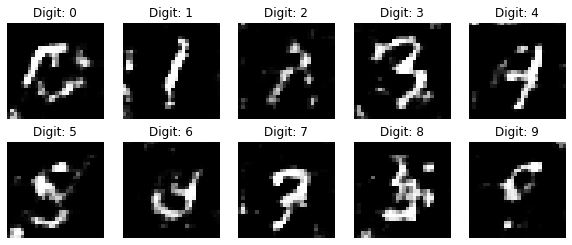

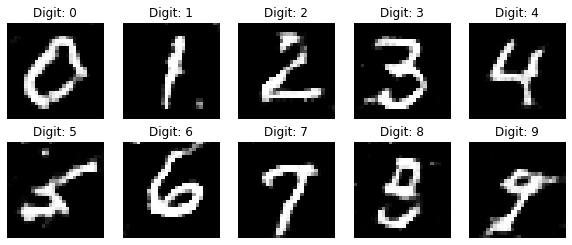

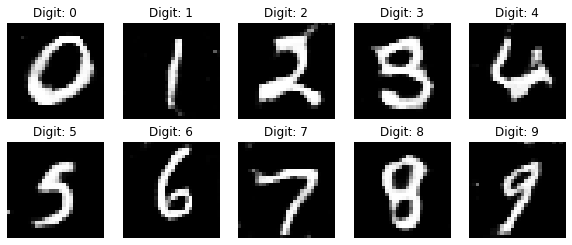

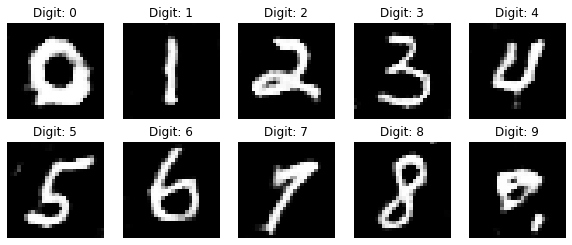

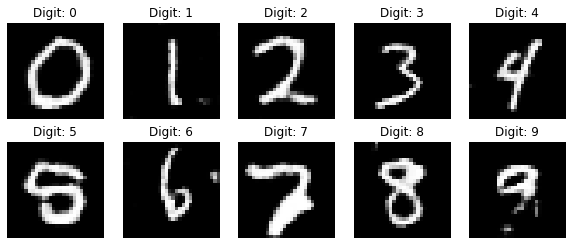

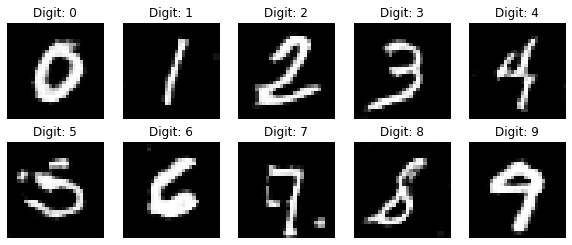

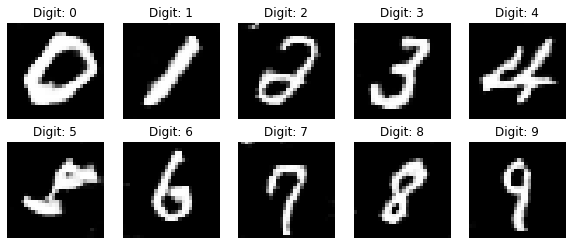

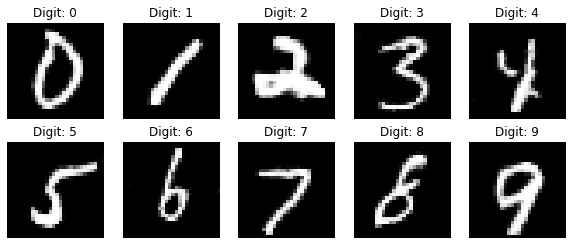

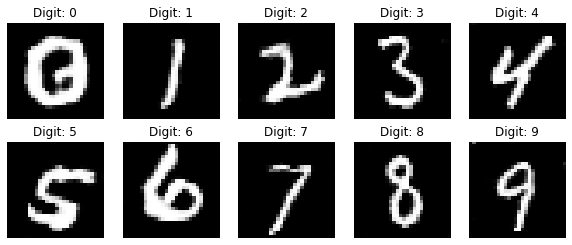

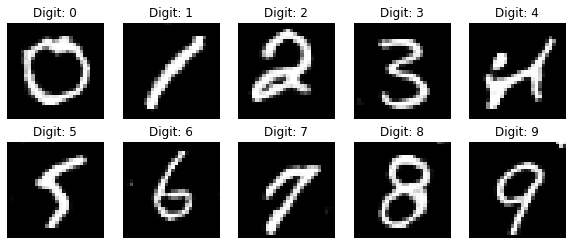

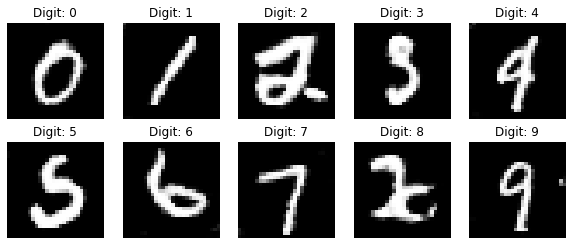

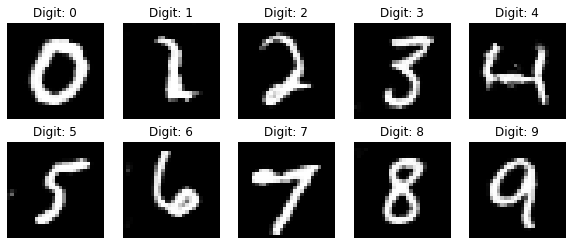

In [ ]:
iterations = 12000
batch_size = 32
sample_interval = 1000

train(iterations, batch_size, sample_interval)

## Output from a Trained CGAN Model

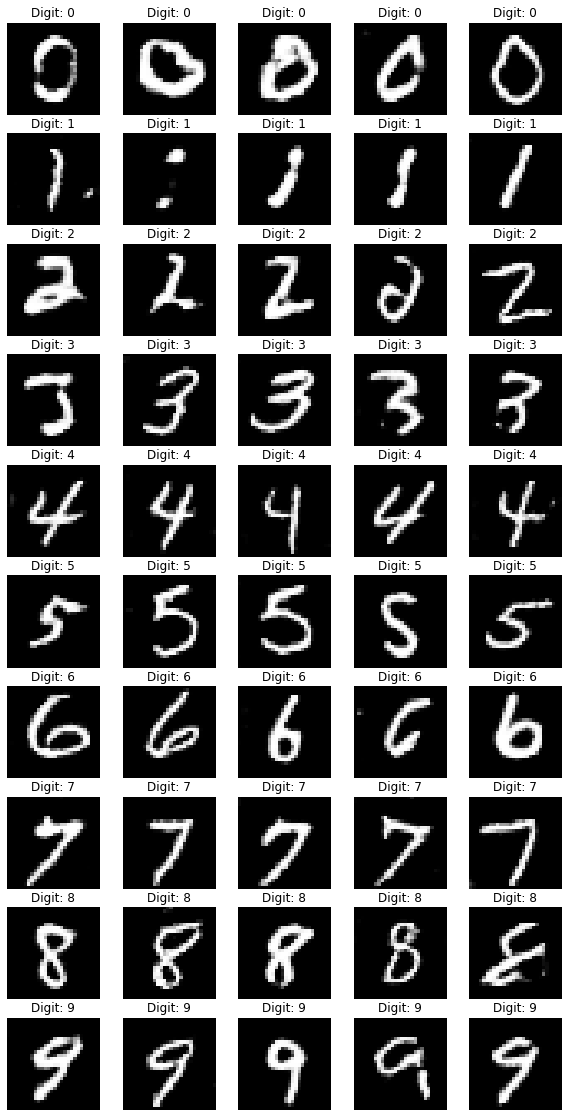

In [ ]:
image_grid_rows = 10
image_grid_columns = 5

z = torch.randn(image_grid_rows * image_grid_columns, z_dim, device=device)

labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten()

labels_to_generate = torch.tensor(labels_to_generate).to(device)

gen_imgs = generator(z,labels_to_generate).cpu().detach()

gen_imgs = 0.5 * gen_imgs + 0.5


fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt].view(28,28), cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])
            cnt += 1